# Chaotic Amplitude Control with momentum (CACm)

Author: Timothee Leleu

Release version     : 1.22 <br>
Create date         : 2023/06/11 Timothee Leleu <br>
Update              : 2023/12/31 Timothee Leleu <br>


# 1) Description

## Introduction

Chaotic Amplitude Control is an algorithm used to find the low-energy states of the Ising Hamiltonian $\mathcal{H}(\boldsymbol{\sigma}) = \frac{1}{2} \boldsymbol{\sigma}^T \Omega \boldsymbol{\sigma}$ with $\boldsymbol{\sigma} \in \{-1,1\}^N$ and $\Omega$ the instance-dependent Ising coupling. The algorithm is based on a relaxation of the binary spins $\boldsymbol{\sigma}$ to soft spins $\boldsymbol{x}$. The dynamics of the soft spins are composed of a gradient descent $\nabla_{\boldsymbol{x}} \mathcal{H}$ of the potential $\mathcal{H}(\boldsymbol{x})$ and the correction of amplitude heterogeneity imposed by the auxiliary variables $\boldsymbol{e}$ (see [1,2]). In addition, a momentum term is added in this version.

## Model

\begin{align}
\boldsymbol{x} (t+1) &= \boldsymbol{x} (t) + \Delta t (- \beta(t) \boldsymbol{x} (t) + \alpha \boldsymbol{e} (t) \circ (\Omega \boldsymbol{\phi}(t)) + \gamma (\boldsymbol{x} (t)-\boldsymbol{x} (t-1)) ),\\
\boldsymbol{e} (t+1) &= \boldsymbol{e} (t) - \xi \boldsymbol{e} (t) \circ (\boldsymbol{x} (t)^2-1)
\end{align}

with

\begin{align}
\frac{1}{N} \sum_i e_i(t) &= 1, \forall t,\\
\beta &= \beta_1 + \frac{t}{T}(\beta_2-\beta_1),
\end{align}

and 

\begin{align}
\phi_i(t) = \text{tanh}(x_i(t)), \forall i.
\end{align}

## Parameters

| Parameter | Interpretation |
| --------------- | --------------- |
| $T$          | Number of time steps         |
| $\beta_1$         | Initial decay rate          |
| $\beta_2$         | Final decay rate          |
| $\alpha$         | Coupling strength          |
| $\gamma$         | Momentum term strength          |
| $\xi$         | Rate of change of auxiliary variables          |
| $\Delta t$         | Time step size          |

## Pseudo-code

```
FOR t IN 0..T-1
    Set beta to beta1 + t/T*(beta2-beta1)   
    Set xpp to xp
    Set xp to x
    Set y to tanh(xp)
    Set mu to w @ y           #Matrix-matrix multiplication
    Set x to xp + Dt*( -beta*xp + alpha*e*mu + gamma*(xp-xpp)  )
    Set e to e - (xp**2-1.0)*e*xi
    Set e to e/mean(e)
    Set s to sign(x)
    Set mu0 to w @ s
    Set H to -0.5 sum(s * mu0)
END FOR
```

## Benchmark

The algorithm is tested on Wishart planted instances. The evaluation metric is the time-to-solution (TTS) defined as TTS = $\frac{\text{log}(1-0.99)}{\text{log}(1-p_0)} T$ where $p_0$ is the probability of finding the ground-state.

## References

[1] Leleu, Timothée, et al. "Destabilization of local minima in analog spin systems by correction of amplitude heterogeneity." Physical review letters 122.4 (2019): 040607.

[2] Leleu, Timothée, et al. "Scaling advantage of chaotic amplitude control for high-performance combinatorial optimization." Communications Physics 4.1 (2021): 266.

# 2) Template code

In [1]:
import numpy as np
import time
import models_pyTorch as models
import params
import lib

#########################################################################
# Define problem

#selection of median instance
Nlist = np.array([60,100,140,200])

#load instance and energy
namelist = ['WISHART_%d_0.80' % N for N in Nlist]

#########################################################################
# General parameters
    
#simulation parameters
K = 10**4
id0 = 0

#########################################################################
# Run
    
TTSCPUl = []
bestE = []
TTSl = []
p0l = []

for N, name in zip(Nlist,namelist):
    
    #load instance
    w    = lib.LoadInstance(name,N,id0)
    H0   = lib.LoadOptimal(name,N)[id0]
    eps0=np.mean(np.abs(w))

    #retrieve user defined parameters
    parameters_array = params.get_userdefparams(N,id0,['CAC'])
 
    #calculate random H
    x = np.random.uniform(0,1,size=[N,K])
    s = np.sign(2*x-1.0)
    h = np.matmul(w,s)
    mH = -0.5*np.sum(h*s,axis=1)

    for method, parameters in zip(['CAC'],parameters_array):

        #renorm weights for Wishart
        if name.split('_')[0] == 'WISHART':
            parameters['alpha'] = parameters['alpha']/eps0

        t0 = time.time()

        Hmin, Hf, p0 = models.simulate_CAC(N,w,H0,K,parameters)

        t1 = time.time()-t0

        if p0[0]>0:
            TTS = (np.log(1-0.99))/(np.log(1-p0[0]))*parameters['T']
            print('Ho/H0: %d/%d, P0: %0.04f, TTS: %d, T: %d, t (s): %0.2f' % (Hmin[0],H0[0],p0[0],TTS,parameters['T'],t1))
        else:
            TTS = np.nan
            print('Ho/H0: %d/%d, P0: %0.04f, TTS: NaN, T: %d, t (s): %0.2f' % (Hmin[0],H0[0],p0[0],parameters['T'],t1))

        Eb = (np.min(Hmin)-np.mean(mH))/(H0-np.mean(mH))

        TTSl.append(TTS)
        p0l.append(p0)
        TTSCPUl.append(t1)
        bestE.append(Eb)


                    

C:\Users\timothee.leleu\Desktop\NTTRI\phi-machines\devs\CACm_1.22\CACm\models_pyTorch.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Hopt = torch.tensor(K,dtype=dtype).to(device)


Ho/H0: -5096760/-5096760, P0: 0.0315, TTS: 8632, T: 60, t (s): 2.35
Ho/H0: -39707200/-39707200, P0: 0.0228, TTS: 19966, T: 100, t (s): 0.59
Ho/H0: -152515440/-152515440, P0: 0.0058, TTS: 118753, T: 150, t (s): 1.28
Ho/H0: -636604000/-636604000, P0: 0.0019, TTS: 702226, T: 290, t (s): 4.27


# 3) Template benchmark: CACm vs. AIM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('plot_style.txt')



Bad key %axes.prop_cycle in file plot_style.txt, line 16 ("%axes.prop_cycle : (cycler('color', ['bc80bd' ,'fb8072', 'b3de69','fdb462','fccde5','8dd3c7','ffed6f','bebada','80b1d3', 'ccebc5', 'd9d9d9']))")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


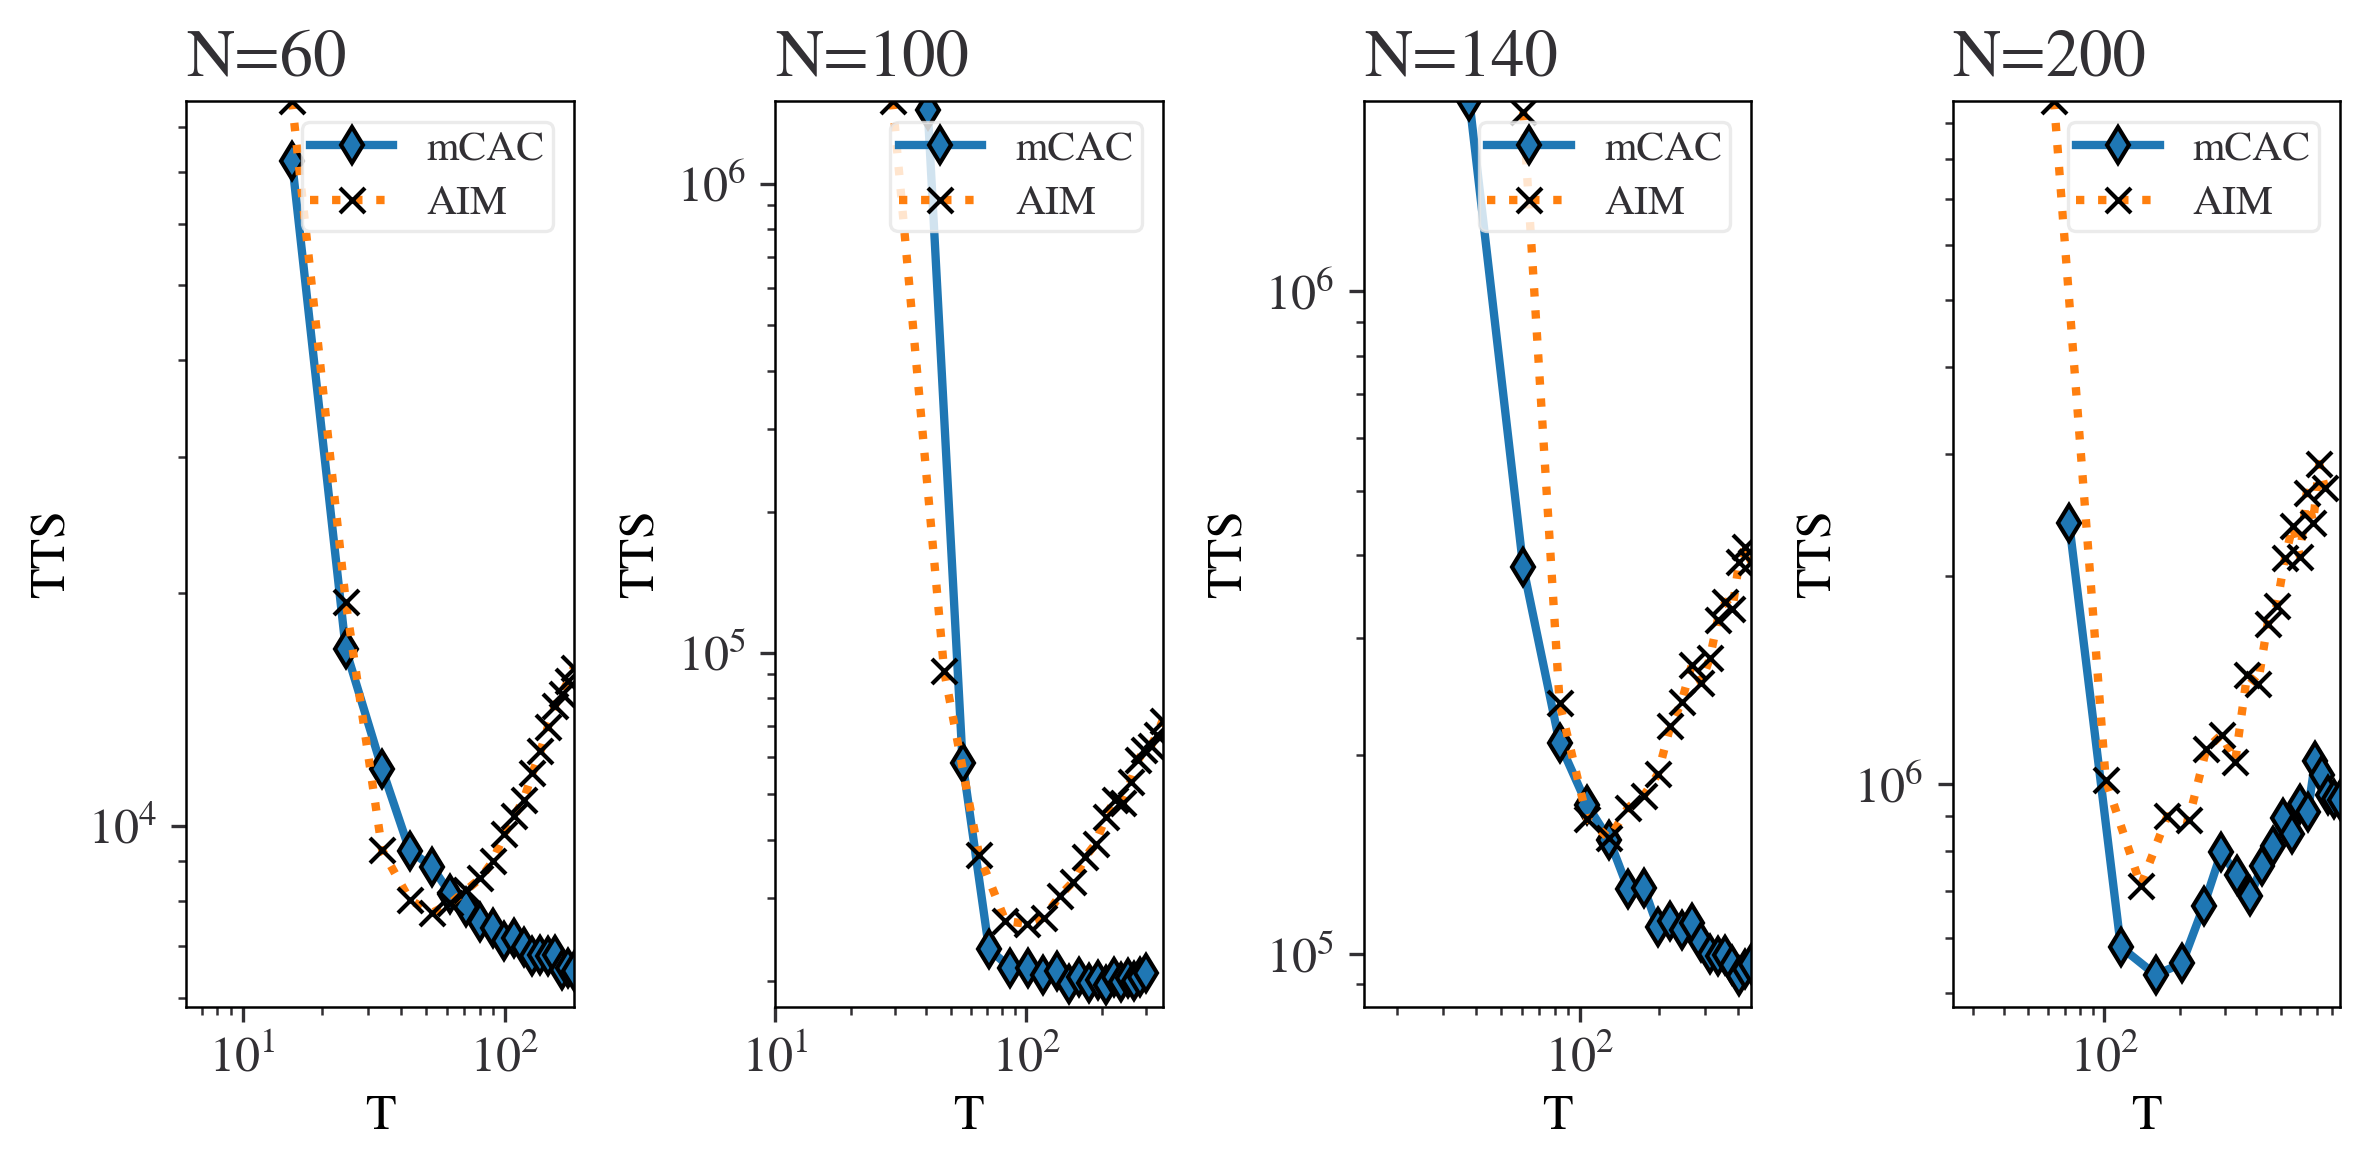

In [3]:
Nlist = [60,100,140,200]
TTSl_CAC = np.load('./../Res/TTSl_CACwmom_T.npy')
par1l_CAC = np.load('./../Res/TTSl_CACwmom_par1l_T.npy')

TTSl_AIM = np.load('./../Res/TTSl_AIM_T.npy')
par1l_AIM = np.load('./../Res/TTSl_AIM_par1l_T.npy')


plt.figure(figsize=(8, 4))

TTSm_CAC = np.reshape(TTSl_CAC,[len(Nlist),len(par1l_CAC)]).T
TTSm_AIM = np.reshape(TTSl_AIM,[len(Nlist),len(par1l_AIM)]).T

T0_CAC = np.array([61,100,150,2.86981758e+02])
T0_AIM = np.array([61,150*0.775,150,250])


for iN, N in enumerate(Nlist):
    
    ax = plt.subplot(1,4,iN+1)

    T_CAC = T0_CAC[iN]*par1l_CAC
    T_AIM = T0_AIM[iN]*par1l_AIM

    ax.plot(T_CAC,TTSm_CAC[:,iN],'d-',label='mCAC')

    ax.plot(T_AIM,TTSm_AIM[:,iN],'x:',label='AIM')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xlabel('T')
    ax.set_ylabel('TTS')
    
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    ax.set_title('N=%d' % N)
    
    ax.set_xlim(np.min(par1l_CAC)*np.min([T0_CAC[iN],T0_AIM[iN]]),np.max(par1l_CAC)*np.max([T0_CAC[iN],T0_AIM[iN]]))
    ax.set_ylim(np.nanmin([np.nanmin(TTSm_CAC[:,iN]),np.nanmin(TTSm_AIM[:,iN])])*0.9,np.nanmax([np.nanmax(TTSm_CAC[:,iN]),np.nanmax(TTSm_AIM[:,iN])]))
    
    ax.legend()
    
ax.set_yscale('log')

ax.set_xlabel('T')
ax.set_ylabel('TTS')

plt.tight_layout()
